In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

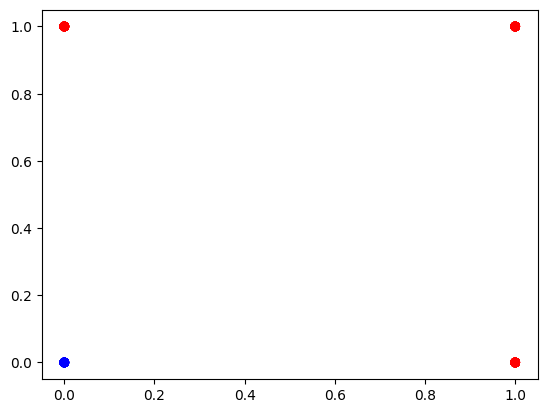

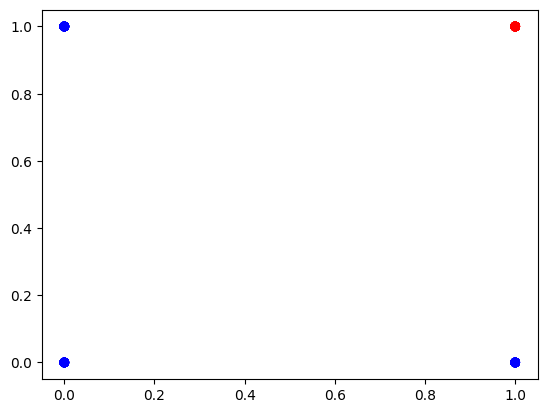

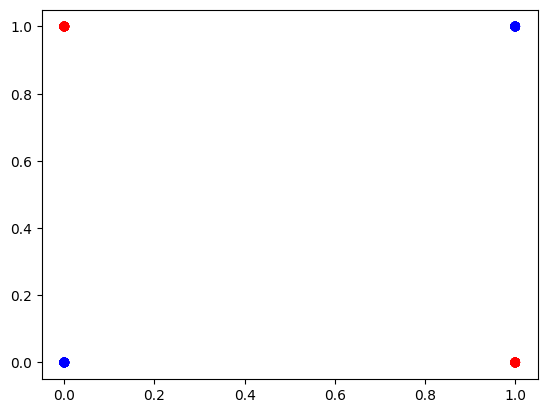

In [6]:
def generate_or_data():
    x = np.random.randint(0, 2, size=(100, 2))
    y = np.array([x[:, 0] | x[:, 1]]).T
    return x, y

def generate_and_data():
    x = np.random.randint(0, 2, size=(100, 2))
    y = np.array([x[:, 0] & x[:, 1]]).T
    return x, y

def generate_xor_data():
    x = np.random.randint(0, 2, size=(100, 2))
    y = np.array([x[:, 0] ^ x[:, 1]]).T
    return x, y

def plot_data(x, y):
    plt.scatter(x[:, 0], x[:, 1], c=y[:, 0], cmap=plt.cm.bwr)
    plt.show()

plot_data(*generate_or_data())
plot_data(*generate_and_data())
plot_data(*generate_xor_data())

# OR

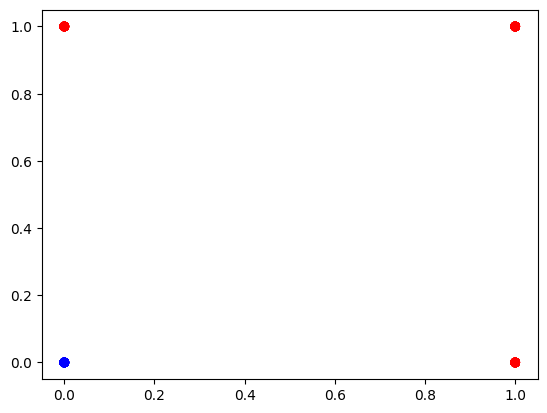

loss: 0.3147, accuracy: 0.2300
loss: 0.1597, accuracy: 0.7200
loss: 0.1289, accuracy: 0.7200
loss: 0.1056, accuracy: 0.7200
loss: 0.0879, accuracy: 1.0000
loss: 0.0745, accuracy: 1.0000
loss: 0.0642, accuracy: 1.0000
loss: 0.0561, accuracy: 1.0000
loss: 0.0496, accuracy: 1.0000
loss: 0.0442, accuracy: 1.0000


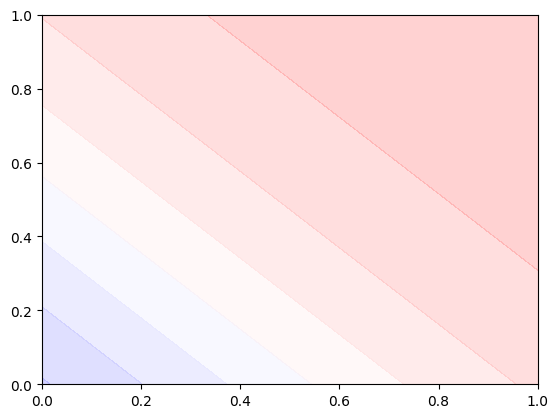

In [57]:
class Model(tf.Module):
    def __init__(self):
        self.w = tf.Variable(tf.random.uniform(shape=[2, 1], minval=-1, maxval=1))
        self.b = tf.Variable(tf.random.uniform(shape=[1], minval=-1, maxval=1))

    def __call__(self, x):
        y = tf.sigmoid(tf.matmul(x, self.w) + self.b)
        return y

model = Model()

def loss_fn(x, y):
    return tf.reduce_mean(tf.square(model(x) - y))

def train(x, y, lr=0.1):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, y)
    grads = tape.gradient(loss, [model.w, model.b])
    model.w.assign_sub(lr * grads[0])
    model.b.assign_sub(lr * grads[1])

def predict(x):
    return model(x)

def accuracy(x, y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(predict(x)), y), tf.float32))

def plot_decision_boundary():
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    xx, yy = np.meshgrid(x, y)
    z = predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.numpy().reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.bwr, alpha=0.2)
    plt.show()

x, y = generate_or_data()

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

plot_data(x, y)

for i in range(1000):
    train(x, y)
    if i % 100 == 0:
        print('loss: {:.4f}, accuracy: {:.4f}'.format(loss_fn(x, y), accuracy(x, y)))

plot_decision_boundary()

# AND

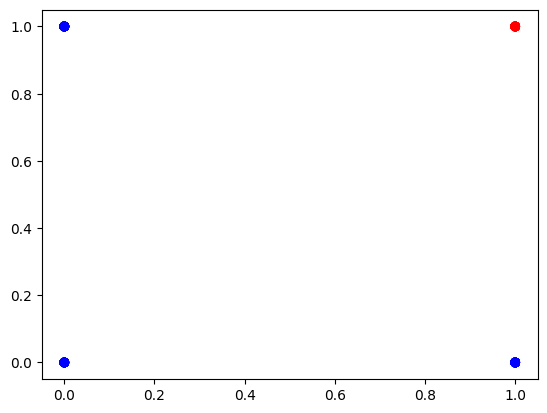

loss: 0.4334, accuracy: 0.1700
loss: 0.1820, accuracy: 0.8300
loss: 0.1531, accuracy: 0.8300
loss: 0.1378, accuracy: 0.8300
loss: 0.1240, accuracy: 0.8300
loss: 0.1113, accuracy: 0.8300
loss: 0.1003, accuracy: 0.8300
loss: 0.0910, accuracy: 0.8300
loss: 0.0830, accuracy: 0.8300
loss: 0.0761, accuracy: 1.0000


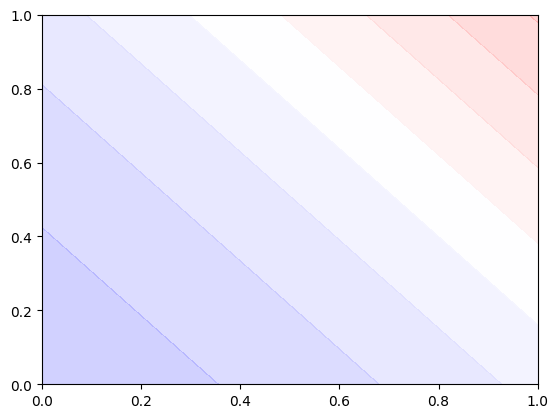

In [63]:
model = Model()

x, y = generate_and_data()

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

plot_data(x, y)

for i in range(1000):
    train(x, y)
    if i % 100 == 0:
        print('loss: {:.4f}, accuracy: {:.4f}'.format(loss_fn(x, y), accuracy(x, y)))

plot_decision_boundary()

# XOR

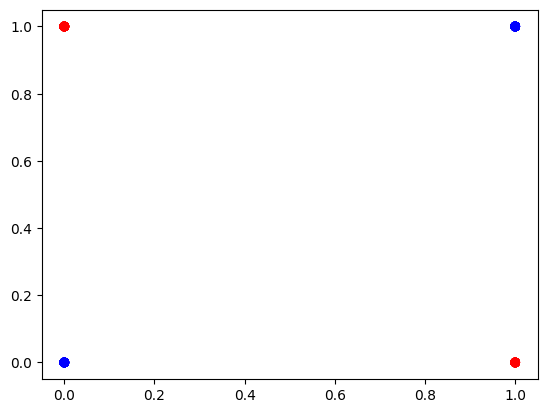

loss: 0.3456, accuracy: 0.5400
loss: 0.2459, accuracy: 0.5400
loss: 0.2431, accuracy: 0.8200
loss: 0.2419, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
loss: 0.2418, accuracy: 0.8200
[[0.46494445 0.46356535 0.46218625 ... 0.33117214 0.32979304 0.32841393]
 [0.4659881  0.464609   0.4632299  ... 0.3322158  0.33083668 0.32945758]
 [0.46703175 0.46565264 0.46427354 ... 0.3332594  0.33188033 0.33050123]
 ...
 [0.56617785 0.5647988  0.56341964 ... 0.4324055  0.43102646 0.42964733]
 [0.56722146 0.56584233 0.56446326 ... 0.43344918 0.43207005 0.43069097]
 [0.5682651  0.566886   0.56550694 ... 0.43449283 0.4331137  0.4317346 ]]


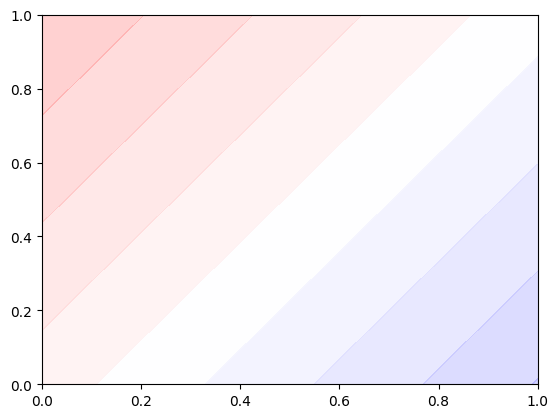

In [97]:
class Layer(tf.Module):
    def __init__(self, out_dim, weight_init=tf.random.uniform, activation=tf.identity):
        self.out_dim = out_dim
        self.weight_init = weight_init
        self.activation = activation
        self.w = None
        self.b = None

    @tf.function
    def __call__(self, x):
        self.in_dim = x.shape[1]
        if self.w is None:
            self.w = tf.Variable(self.weight_init(shape=[self.in_dim, self.out_dim]))
        if self.b is None:
            self.b = tf.Variable(tf.zeros(shape=[self.out_dim]))
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)

class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function
    def __call__(self, x, preds=False): 
        for layer in self.layers:
            x = layer(x)
        return x

model = MLP([
    Layer(2, activation=tf.nn.relu),
    Layer(1, activation=tf.nn.relu)
])

x, y = generate_xor_data()

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

plot_data(x, y)

def accuracy(x, y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(model(x)), y), tf.float32))

def loss_fn(x, y):
    return tf.reduce_mean(tf.square(model(x) - y))

def train(x, y, lr=0.1):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, y)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

def plot_decision_boundary():
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    xx, yy = np.meshgrid(x, y)
    z = model(np.c_[xx.ravel(), yy.ravel()])
    z = z.numpy().reshape(xx.shape)
    print(z)
    plt.contourf(xx, yy, z, cmap=plt.cm.bwr, alpha=0.2)
    plt.show()

for i in range(1000):
    train(x, y)
    if i % 100 == 0:
        print('loss: {:.4f}, accuracy: {:.4f}'.format(loss_fn(x, y), accuracy(x, y)))

plot_decision_boundary()